# COCO Reader

Reader operator that reads a COCO dataset (or subset of COCO), which consists of an annotation file and the images directory.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np

file_root = "/data/coco/coco-2017/coco2017/val2017"
annotations_file = "/data/coco/coco-2017/coco2017/annotations/instances_val2017.json"
num_gpus = 1
batch_size = 16

In [2]:
class COCOPipeline(Pipeline):                                                                    
    def __init__(self, batch_size, num_threads, device_id):                                       
        super(COCOPipeline, self).__init__(batch_size, num_threads, device_id, seed = 15)        
        self.input = ops.COCOReader(file_root = file_root, annotations_file = annotations_file,
                                     shard_id = device_id, num_shards = num_gpus)
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)                        
                                                                                                  
    def define_graph(self):                                                                       
        inputs, bboxes = self.input()            
        images = self.decode(inputs)                                                                                                      
        return (images, bboxes)                                                         

In [3]:
pipe = COCOPipeline(batch_size=batch_size, num_threads=2, device_id = 0)   
pipe.build()                                                                

In [4]:
pipe_out = pipe.run()                                                   
                                                                            
images_cpu = pipe_out[0].asCPU()
bboxes_cpu = pipe_out[1]

Bounding boxes returned by the operator are lists of floats containing 5 elements:
\[x, y, width, height, category_id]

In [5]:
bboxes = bboxes_cpu.at(9)
bboxes

array([[ 28.03, 252.91, 293.72, 239.92,  70.  ],
       [ 53.25,  61.04, 248.05,  84.41,  81.  ]], dtype=float32)

Let's see the ground truth bounding boxes drawn on the image.

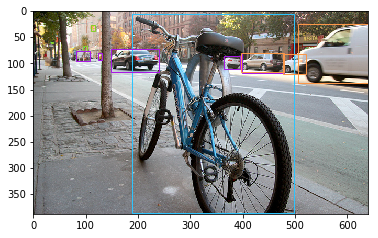

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

img_index = 4

img = images_cpu.at(img_index)

fig,ax = plt.subplots(1)

ax.imshow(img)
bboxes = bboxes_cpu.at(img_index)
categories_set = set()
for bbox in bboxes:
    categories_set.add(int(bbox[4]))

category_id_to_color = dict([ (cat_id , [random.uniform(0, 1) ,random.uniform(0, 1), random.uniform(0, 1)]) for cat_id in categories_set])

for bbox in bboxes:
    category_id = int(bbox[4])
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor=category_id_to_color[category_id],facecolor='none')
    ax.add_patch(rect)

plt.show()
